# Crack Me If You Can 2023 Example Notebook

### Getting Started
This Jupyter Notebook has been set up to demonstrate how to use this framework. Think of it as a training lesson. Feel free to modify this to fit your own needs or create your own Notebooks to better fit your workflow.

If you edit the core python classes are stored in .py files in lib_framework, you will need to reload the kernel for this workbook for those changes to be applied. You can do this by clicking on the "fast forward (two arrows)" button in the top ribbon above this. That being said, you can access all of the class datastructures in the cells below and write your own code to parse them. The code in the cells will be applied when you run that cell, which makes it very easy to run some quick tests on the underlying data without having to reload everything.

### Loading the configuration and the initial challenge files

Core information about your cracking session is stored in the SessionMgr (Session Manager) class. The SessionMgr handles storing information about password hashes, password metadata, password plaintext values, and information about your cracking setup. The cracking setup contains information about your John the Ripper and Hashcat configurations, as well as the various potfiles you may be managing. This means the SessionMgr fills two different use-cases:
1. Performing analysis on cracked passwords and uncracked password metadata
2. Managing and automating many of the password cracking tasks you may have like syncing pot files between multiple different sessions.

To that end, by default SessionMgr will load and parse all of the challenge files listed in your config file. This can take a couple of minutes sometimes, so if you want to use this to automate your workflow and not perform analysis you can instead call the init function using **SessionMgr(config_file, load_challenge=False)** If you do this it will not load the password hashes, but you can still use it to sync your password files (Ed. Note: This is a TBD feature and not fully implimented yet).

In the example below, it initializes the SessionMgr to load everything including challenge hashes.

In [1]:
from lib_framework.session_mgr import SessionMgr

config_file = "config.yml"

sm = SessionMgr(config_file)

Starting to load challenge yaml file. This may take a minute or two


### Loading cracked passwords (Pot Files)

The next step is to load all the cracked passwords (Pot Files). One for John the Ripper cracking sessions, and the other for Hashcat cracking sessions. The format for these files is slighly different which is why they are not combined. The main pot files are specified in the config file that you loaded earlier. These pot files should be unique for this contest and not contain cracked passwords from your day job. Also I'd recommend against loading/updating them if you have current password cracking sessions being run that are writing to them since I don't know how to properly lock those files without interfearing with running cracking sessions.

After both pot files are loaded, the next step is to update them with cracked passwords found in the other pot files. This will be helpful so you aren't cracking the same salted password twice, and can be leveraged in loopback attacks.

In [2]:
sm.load_main_pots(verbose=False)
sm.update_main_pots()

Number of new plains added to the JtR pot file: 0
Number of new plains added to the Hashcat pot file: 0


In [3]:
sm.print_status()

Algorithm     :Total      :Cracked   :Remaining :Percentage
md5crypt       :3231      :62        :3169      :2%
ssha           :3239      :0         :3239      :0%
bcrypt         :3400      :57        :3343      :2%
raw-md5        :3247      :329       :2918      :10%
raw-sha256     :3307      :243       :3064      :7%
sha256crypt    :3388      :58        :3330      :2%
raw-sha1       :3328      :345       :2983      :10%
ssha512        :3439      :109       :3330      :3%
sha1crypt      :3268      :61        :3207      :2%


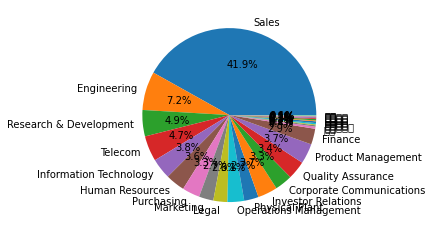

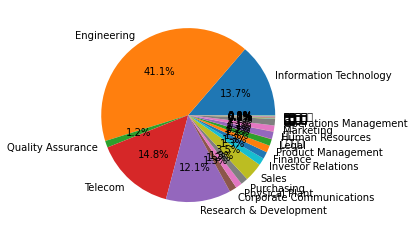

In [4]:
import warnings
warnings.filterwarnings('ignore')

sm.pie_graph_metadata("Department", True)
sm.pie_graph_metadata("Department", False)